# Problem 3: Google Playstore Apps Dataset (63 points)

In [292]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from numpy import nan as NA
import re

In [293]:
df = pd.read_excel('GooglePlaystore.xlsx')

## Preprocessing

1. [3 pts] Often there are outliers which do not match the overall data type. 
There is one record in this data where the "Reviews" has value "3.0M" which does not match the rest of the data. Remove that record.

In [294]:
df = df[df['Reviews'] != '3.0M'] # Records in which the Reviews attribute is not 3.0M

2. [4 pts] Remove rows where any of the columns has the value "Varies with device"

In [295]:
target = 'Varies with device'
rowsCheck = df.isin([target]) # boolean table
rowsCheck = rowsCheck.any(axis=1) # any column contains the value one -> record gets mapped to True
#print(len(df[rowsCheck]))
df = df[~rowsCheck]

3. [5 pts] The values in the Android version column should be floats. Strip the trailing non-numeric characters from all values (ie. the words " and up"), so the result is a number. If there are multiple decimal places (eg. "x.y.z"), keep only the first two parts (eg "x.y"). For example, the value "4.1 and up" should be changed to "4.1". The value "4.5.6 and up" should be changed to "4.5". The value "5.6.7" should be changed to "5.6". If there is a range (eg. 5.0 - 8.0), only consider the first number. For example, the value "5.0 - 8.0" should be changed to "5.0". The value "4.0.3 - 7.1.1" should be changed to "4.0".

In [296]:
# 2 records were found to have NaN, therefore str check.
three = lambda i : i.strip()[0:3] if type(i) == str else i
df['Android Ver'] = df['Android Ver'].apply(three)

4. [5 pts] The "Installs" column must have integer values. For values that have commas, remove the commas. For values that have a '+' at the end, remove the '+'. Keep only those rows that have an integer value after these edits.

In [297]:
intify = lambda s : int(re.sub(r'\,|\+$', "", s) if re.sub(r'\,|\+$', "", s).isnumeric() else -1)

# change the string to integer. if we set that integer to -1 then it was invalid
df['Installs'] = df['Installs'].apply(intify)

# get rid of rows where Installs attribute = -1 for those were the rows that didn't have integer value after edit
df = df[df["Installs"] != -1]

5. [5 pts] For missing rating values, if the number of reviews is less than 100 and installations is less than 50000, remove the row. Else, fill the missing value with the average value (rounded to 2 decimal places) for the Category of that row.

In [298]:
# Documentation: Groupby one column and return the mean of only particular column in the group.
avg_ratings_by_category = df.groupby(by="Category")['Rating'].mean()
avg_ratings_by_category = round(avg_ratings_by_category, 2)
# ^ Series indexable by category

notfixable_cond = (df['Rating'].isna()) & (df['Reviews'] < 100) & (df['Installs'] < 50000)
df = df[~notfixable_cond] # Remove those that are not fixable

# Find those that can be fixed
fixable_cond = (df['Rating'].isna()) & ((df['Reviews'] >= 100) | (df['Installs'] >= 50000))

# Inplace change on those which are fixable
indices = df[fixable_cond].index
for i in indices:
    avg_rating = avg_ratings_by_category[df.loc[i]['Category']]
    df.loc[i, 'Rating'] = avg_rating
    

6. [6 pts] Preprocess the Size column to convert the "M" (millions) and "K" (thousands) values into integers. For instance, 8.7M should be converted to 8700000 and 2.4K should be converted to 2400.

In [299]:
convertMorK = lambda x : 10 ** 6 if x == "M" or x == "m" else 10 ** 3 if x == "K" or x=="k" else -1

# Returns np.nan on failure
def convertsix(i):
    if(type(i) == str):
        i = i.strip()
        value = float(i[0:-1])
        power = i[-1]
        value *= convertMorK(power)        
        return int(value) if value > 0 else NA
    else:
        return i
    

df['Size'] = df['Size'].apply(convertsix)

## Analysis 

1. [4 pts] Describe (use DataFrame describe method) the category wise rating statistics. In other words, for each category, describe the statistics (count, mean, etc.) for ratings in that category.

In [300]:
df.groupby(by="Category")['Rating'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
ART_AND_DESIGN,59.0,4.358644,0.365322,3.2,4.100,4.40,4.700,5.0
AUTO_AND_VEHICLES,62.0,4.146774,0.569935,2.1,3.900,4.25,4.500,4.9
BEAUTY,40.0,4.291750,0.356175,3.1,4.075,4.30,4.525,4.9
BOOKS_AND_REFERENCE,147.0,4.320136,0.453084,2.7,4.100,4.40,4.600,5.0
BUSINESS,246.0,4.119187,0.662586,1.0,3.825,4.30,4.500,5.0
COMICS,49.0,4.154082,0.550363,2.8,3.800,4.40,4.600,5.0
COMMUNICATION,210.0,4.100952,0.502624,1.0,3.900,4.20,4.400,5.0
DATING,174.0,3.957816,0.664204,1.0,3.600,4.10,4.400,5.0
EDUCATION,110.0,4.392636,0.254395,3.5,4.300,4.40,4.600,4.9


2. [11 pts] Extract all "Free" apps from the master data frame. Then write a function that, given a numeric column e.g 'Rating'), will create and return a dataframe for the top 3 free applications in each category based on that column. Call the function on each of these columns:

    Rating (gives top 3 most highly rated applications in each category)
    Installs (gives top 3 most installed applications in each category)
    Reviews (gives top 3 most reviewed applications in each category)

You don't need to do anything explicit to break ties.

Each of the returned dataframes have Category and App for the first two columns, and one of Rating (for a.), Installs (for b.), and Reviews (for c.) as the third column.

In [301]:
# Extract all free apps from master dataframe
df_free = df[df['Type'] == "Free"].copy()

# The function passed to apply must take a dataframe as its first argument and return a DataFrame, Series or scalar.
# apply will then take care of combining the results back together into a single dataframe or series. 
def helper(input_dataframe, input_column):
    three_df = input_dataframe.copy()
    three_df = three_df.sort_values([input_column], ascending=False) # sort descending based on column
    return three_df[['Category', 'App', input_column]].iloc[0:3,] # return top 3 records for Category,App,? columns

# This is the function to call
def func(inputcolumn):
    return df_free.groupby(by='Category').apply(helper, input_column=inputcolumn)
    

In [302]:
func('Rating')

Category  \
Category                                    
ART_AND_DESIGN    8888     ART_AND_DESIGN   
                  6930     ART_AND_DESIGN   
                  3982     ART_AND_DESIGN   
AUTO_AND_VEHICLES 64    AUTO_AND_VEHICLES   
                  79    AUTO_AND_VEHICLES   
...                                   ...   
VIDEO_PLAYERS     8459      VIDEO_PLAYERS   
                  5244      VIDEO_PLAYERS   
WEATHER           3627            WEATHER   
                  3629            WEATHER   
                  3631            WEATHER   

                                                                App  Rating  
Category                                                                     
ART_AND_DESIGN    8888      Spring flowers theme couleurs d t space     5.0  
                  6930         Fantasy theme dark bw black building     4.8  
                  3982                            Cardi B Wallpaper     4.8  
AUTO_AND_VEHICLES 64          DMV Permit Practice Test 2018 Edition     4.9  
                  79                        Tickets + PDA 2018 Exam     4.9  
...                                                             ...     ...  
VIDEO_PLAYERS     8459  Video Downloader - for Instagram Repost App     4.8  
                  5244                                    AJ Player     4.8  
WEATHER           3627                             Weather forecast     4.8  
                  3629                             Live Weather Pro     4.8  
                  3631                   weather - weather forecast     4.7  

[99 rows x 3 columns]

In [303]:
func('Installs')

Category  \
Category                                    
ART_AND_DESIGN    19       ART_AND_DESIGN   
                  12       ART_AND_DESIGN   
                  45       ART_AND_DESIGN   
AUTO_AND_VEHICLES 8289  AUTO_AND_VEHICLES   
                  70    AUTO_AND_VEHICLES   
...                                   ...   
VIDEO_PLAYERS     4032      VIDEO_PLAYERS   
                  3693      VIDEO_PLAYERS   
WEATHER           4725            WEATHER   
                  5768            WEATHER   
                  3636            WEATHER   

                                                                      App  \
Category                                                                    
ART_AND_DESIGN    19                                         ibis Paint X   
                  12                       Tattoo Name On My Photo Editor   
                  45    Canva: Poster, banner, card maker & graphic de...   
AUTO_AND_VEHICLES 8289                      AutoScout24 - used car finder   
                  70    Fines of the State Traffic Safety Inspectorate...   
...                                                                   ...   
VIDEO_PLAYERS     4032                                           Dubsmash   
                  3693               LIKE – Magic Video Maker & Community   
WEATHER           4725                 Weather & Clock Widget for Android   
                  5768                                      Amber Weather   
                  3636                   Weather –Simple weather forecast   

                         Installs  
Category                           
ART_AND_DESIGN    19     10000000  
                  12     10000000  
                  45     10000000  
AUTO_AND_VEHICLES 8289   10000000  
                  70      5000000  
...                           ...  
VIDEO_PLAYERS     4032  100000000  
                  3693   50000000  
WEATHER           4725   50000000  
                  5768   10000000  
                  3636   10000000  

[99 rows x 3 columns]

In [304]:
func('Reviews')

Category  \
Category                                    
ART_AND_DESIGN    19       ART_AND_DESIGN   
                  18       ART_AND_DESIGN   
                  45       ART_AND_DESIGN   
AUTO_AND_VEHICLES 79    AUTO_AND_VEHICLES   
                  8289  AUTO_AND_VEHICLES   
...                                   ...   
VIDEO_PLAYERS     4038      VIDEO_PLAYERS   
                  4032      VIDEO_PLAYERS   
WEATHER           4725            WEATHER   
                  5768            WEATHER   
                  3627            WEATHER   

                                                                      App  \
Category                                                                    
ART_AND_DESIGN    19                                         ibis Paint X   
                  18                        FlipaClip - Cartoon animation   
                  45    Canva: Poster, banner, card maker & graphic de...   
AUTO_AND_VEHICLES 79                              Tickets + PDA 2018 Exam   
                  8289                      AutoScout24 - used car finder   
...                                                                   ...   
VIDEO_PLAYERS     4038  DU Recorder – Screen Recorder, Video Editor, Live   
                  4032                                           Dubsmash   
WEATHER           4725                 Weather & Clock Widget for Android   
                  5768                                      Amber Weather   
                  3627                                   Weather forecast   

                        Reviews  
Category                         
ART_AND_DESIGN    19     224399  
                  18     194216  
                  45     174531  
AUTO_AND_VEHICLES 79     197136  
                  8289   186648  
...                         ...  
VIDEO_PLAYERS     4038  2588730  
                  4032  1971777  
WEATHER           4725  2371543  
                  5768   260137  
                  3627   159455  

[99 rows x 3 columns]

3. [4 pts] Find the average, maximum and minimum price of the paid applications.

In [305]:
paidAnalysis = df.copy()
paidAnalysis = paidAnalysis[paidAnalysis['Type'] == 'Paid']

d = dict()
d["Average"] = round(paidAnalysis['Price'].mean(),2)
d["Maximum"] = paidAnalysis['Price'].max()
d["Minimum"] = paidAnalysis['Price'].min()

paidAnalysis = DataFrame.from_dict(d, orient="index", columns=['Price Statistics'])
paidAnalysis

,Price Statistics
Average,15.14
Maximum,400.00
Minimum,0.99


## Visualization

1. [9 pts] In the genre column, break the string of genres into a list. For example, ‘Art & Design; Creativity’ should be [‘Art & Design’, Creativity’].
Count the number of applications per genre and display it using a pie chart.
Hint: Read about DataFrame.explode()

In [306]:
vs = df.copy()
# Change the Genres to a list
vs['Genres'] = vs['Genres'].str.split(";")
vs = vs.explode('Genres') # Documentation: Transform each element of a list-like to a row, replicating index values.

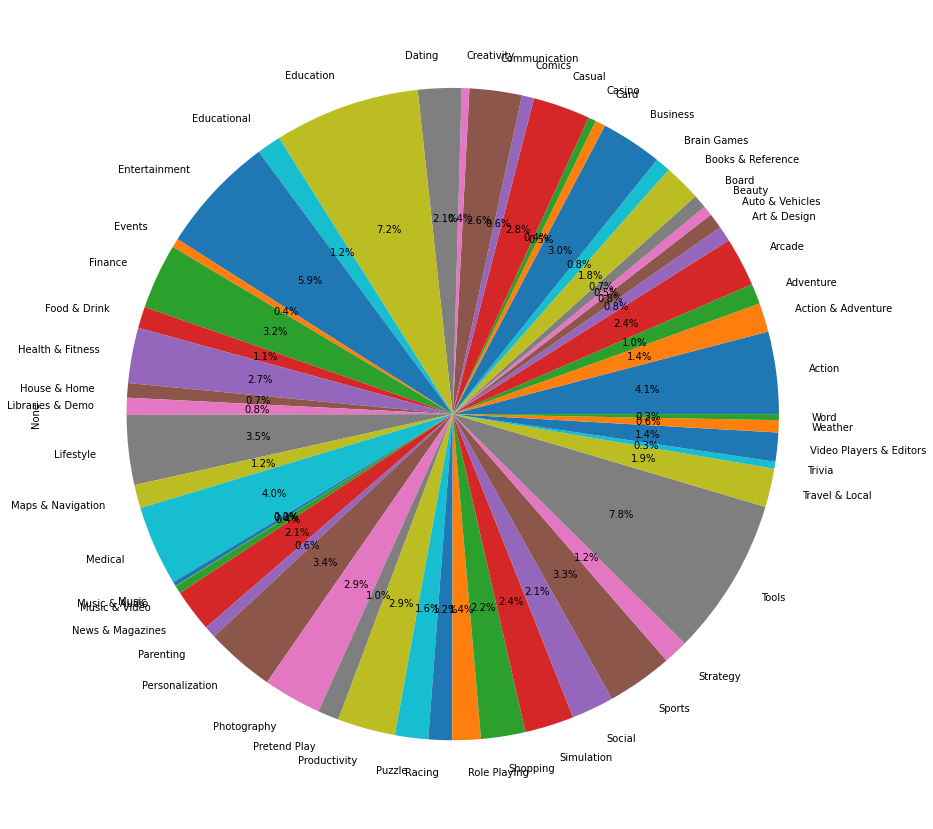

In [307]:
vs_series = vs.groupby(by="Genres").size() # Index = Genre name, Value = # of apps in that Genre
vs_piechart = vs_series.plot.pie(figsize=(15,15), autopct='%1.1f%%')

2. [7 pts] Display a box plot of ratings for "Business" and "Education" categories. The boxplots should be in the same plot.

Text(0, 0.5, 'Category')

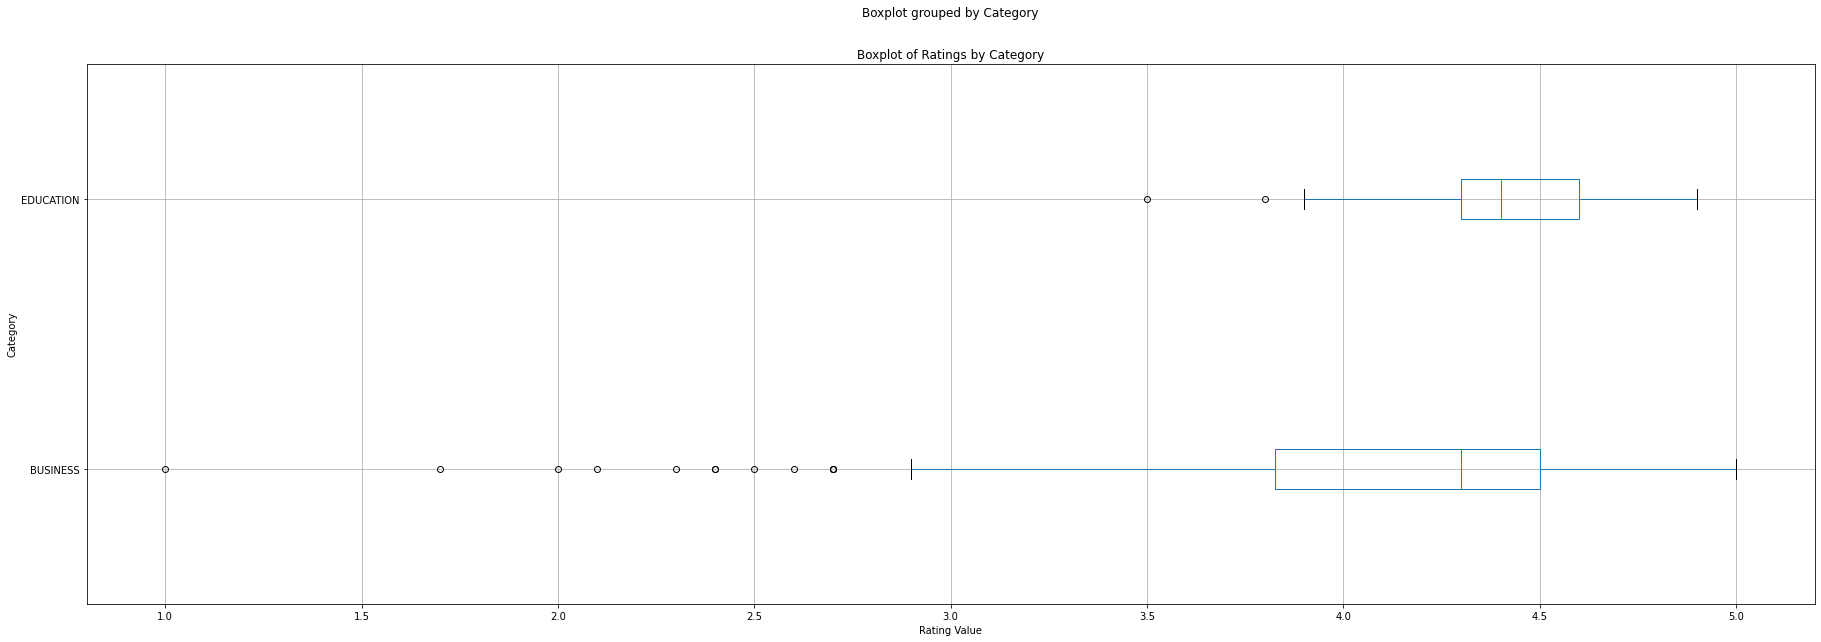

In [308]:
be_df = df.copy()
b = be_df['Category'] == 'BUSINESS'
e = be_df['Category'] == 'EDUCATION'
be_df = be_df[b | e] # apply boolean mask

# Generate boxplot in the same plot. one for Business category and the other for education category
# Documentation: Column in the DataFrame to pandas.DataFrame.groupby(). One box-plot will be done per value of columns in by.
# The column with values is Rating, but we need to group by Category
boxplot = be_df.boxplot(column='Rating', by='Category', figsize=(30, 10), vert=False)
boxplot.set_title("Boxplot of Ratings by Category")
boxplot.set_xlabel('Rating Value')
boxplot.set_ylabel('Category')
# I couldn't find how to turn the default topmost rating off

`The End`